# Topic Modeling

- Using Gensim (LDA, LSI, HDP, etc)

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,mlxtend,omegaconf,gensim --conda

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.26.0

numpy    : 1.26.0
pandas   : 2.2.2
polars   : 1.4.1
mlxtend  : 0.23.1
omegaconf: not installed
gensim   : 4.3.3

conda environment: n/a



In [2]:
# Built-in library
from pathlib import Path
from pathlib import Path
import re
import json
from typing import Any, Literal, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")


# auto reload imports# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(500)

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

### Load Data

In [3]:
pl.Config.set_fmt_str_lengths(20)
pl.set_random_seed(seed=123)


fp: str = "../data/articles_final_df.parquet"
articles_df: pl.DataFrame = pl.read_parquet(fp)
print(f"{articles_df.shape = }")
articles_df.head(2)

articles_df.shape = (9335, 10)


articleID,articleWordCount,documentType,pubDate,source,typeOfMaterial,metadata,metadata_1,metadata_2,is_high_engagement
str,i64,str,date,str,str,str,str,str,u8
"""58927e0495d0e0392607…",1129,"""article""",2017-02-02,"""The New York Times""","""news""","""ken belson n f l vs …","""ken belson n f l vs …","""ken belson n f l vs …",0
"""5893033d95d0e0392607…",3082,"""article""",2017-02-02,"""The New York Times""","""news""","""unknown voice vice v…","""unknown voice vice v…","""unknown voice vice v…",1


In [4]:
data_df: pl.DataFrame = articles_df.select(["articleID", "metadata_1"]).rename(
    {"articleID": "article_id", "metadata_1": "text"}
)
data_df.head(3)

article_id,text
str,str
"""58927e0495d0e0392607…","""ken belson n f l vs …"
"""5893033d95d0e0392607…","""unknown voice vice v…"
"""5893039595d0e0392607…","""manohla dargis a sta…"


### Text Preprocessing

- Drop stopwords.
- Drop non-alphanumeric characters.
- Tokenize the corpus.
- Create wordcloud.

In [5]:
import spacy
from spacy.lang import en


nlp = spacy.load(
    "en_core_web_md",
    disable=["parser", "ner"],
    # disable=["tagger", "parser", "ner"],
)

corpus: list[str] = [
    "Today is a good day 123 *() girls girl was",
    "Syntactically similar words generally have high similarity in fastText models,",
    "since a large number of the component char-ngrams will be the same. As a result",
    "fastText generally does better at syntactic tasks than Word2Vec.",
]

tokens: list[list[str]] = []
for doc in nlp.pipe(corpus[:2]):
    # Add alpha-numeric lemmatized tokens
    tokens.append([token.lemma_ for token in doc if token.text.isalnum()])

tokens

[['today', 'be', 'a', 'good', 'day', '123', 'girl', 'girl', 'be'],
 ['syntactically',
  'similar',
  'word',
  'generally',
  'have',
  'high',
  'similarity',
  'in',
  'fastText',
  'model']]

In [6]:
from opinion_mine.data_prep.utilities import (
    tokenizer_spacy,
    save_tokenized_corpus,
    stream_corpus,
    MyCorpus,
    create_wordcloud,
)

In [7]:
tokenizer_spacy(
    nlp, corpus=corpus[:1], batch_size=500, n_process=1, drop_stopwords=True
)

[['today', 'good', 'day', '123', 'girl', 'girl']]

In [8]:
# # Tokenize the corpus
# tok_corpus: list[list[str]] = tokenizer_spacy(
#     nlp,
#     corpus=data_df["text"].to_list(),
#     batch_size=1_000,
#     n_process=1,
#     drop_stopwords=True,
# )

# sp: str = "../data/tokenized_corpus.txt"
# save_tokenized_corpus(tok_corpus=tok_corpus, filepath=sp, separator=",")

In [9]:
# from typing import Iterator
# from smart_open import open


# class MyCorpusIterator:
#     def __init__(self, filepath: str, separator: str = ",") -> None:
#         self.file = open(filepath, "r")
#         self.separator = separator

#     def __iter__(self):
#         return self

#     def __next__(self):
#         line = self.file.readline()
#         if not line:
#             self.file.close()
#             raise StopIteration
#         return line.strip().split(self.separator)


# class MyCorpus:
#     def __init__(self, filepath: str, separator: str = ",") -> None:
#         self.filepath = filepath
#         self.separator = separator

#     def __repr__(self) -> str:
#         return f"{self.__class__.__name__}(filepath={self.filepath!r})"

#     def __iter__(self) -> Iterator[list[str]]:
#         return MyCorpusIterator(self.filepath, self.separator)


# corpus_iterator: MyCorpus = MyCorpus(filepath=sp, separator=",")
# print(next(iter(corpus_iterator)))

### Create:

- Gensim corpus
- Word cloud

In [10]:
fp: str = "../data/tokenized_corpus.txt"

corpus_iterable: MyCorpus = MyCorpus(filepath=fp, separator=",")
corpus_iterable

MyCorpus(filepath='../data/tokenized_corpus.txt')

In [11]:
print(next(iter(corpus_iterable)))

['ken', 'belson', 'vs', 'politic', 'battle', 'season', 'long', 'football', 'super', 'bowl', 'national', 'football', 'league', 'new', 'england', 'patriot', 'goodell', 'roger', 'lady', 'gaga', 'immigration', 'emigration', 'trump', 'donald', 'sports', 'despite', 'national', 'tumult', 'immigration', 'spill', 'commissioner', 'roger', 'goodell', 'say', 'singularly', 'focus', 'super', 'bowl', 'right', 'pro', 'football']


In [12]:
from gensim import corpora, models

dictionary: corpora.Dictionary = corpora.Dictionary(documents=corpus_iterable)
print(dictionary)

# Get the id of the 1st 2 tokens
list(dictionary.token2id.items())[:3]

Dictionary<22756 unique tokens: ['battle', 'belson', 'bowl', 'commissioner', 'despite']...>


[('battle', 0), ('belson', 1), ('bowl', 2)]

#### Create Word Cloud

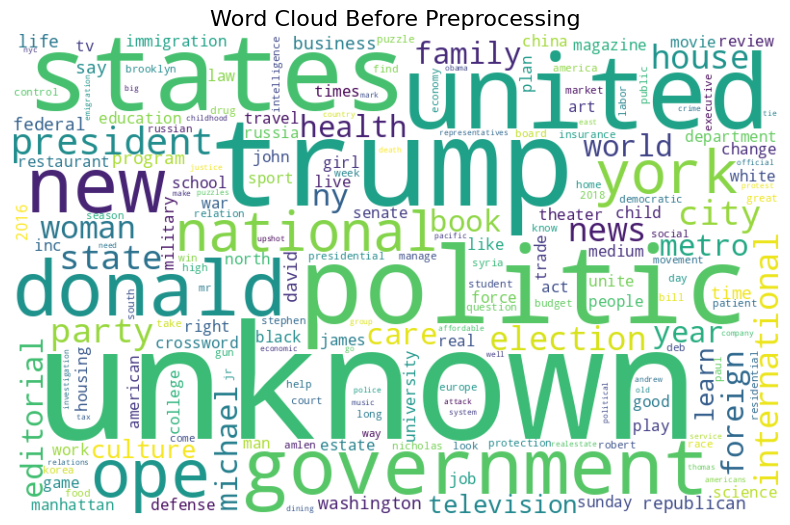

In [13]:
N: int = 5_000
frequencies: dict[str, int] = dict(dictionary.most_common()[:N])
create_wordcloud(frequencies, title="Word cloud before preprocessing")

In [14]:
min_token_freq: int = (
    1  # Keep tokens which are contained in at least no_below documents.
)
max_token_freq: float = 0.8  # Keep tokens in at most N% of documents.

# Filter low-freq and high-freq words
dictionary.filter_extremes(no_below=min_token_freq, no_above=max_token_freq)

# Remove gaps in id sequence after words are filtered
dictionary.compactify()
print(dictionary)

Dictionary<22756 unique tokens: ['battle', 'belson', 'bowl', 'commissioner', 'despite']...>


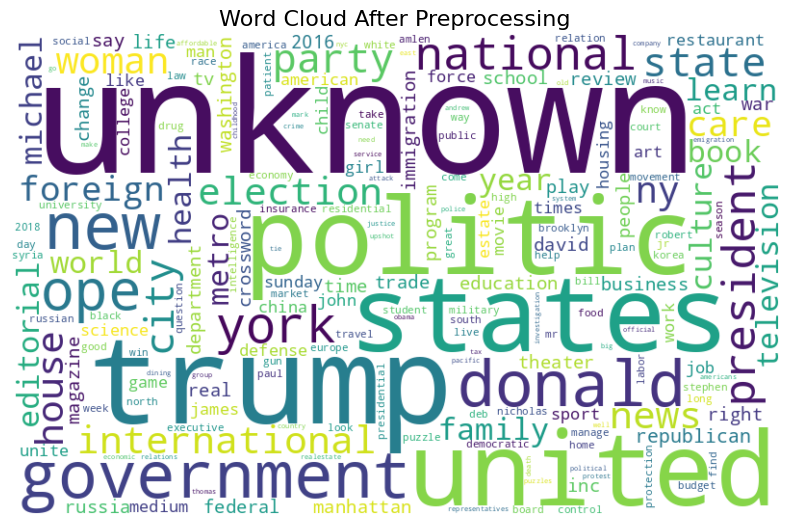

In [15]:
N: int = 5_000
frequencies: dict[str, int] = dict(dictionary.most_common()[:N])
create_wordcloud(frequencies, title="Word cloud after preprocessing")

In [16]:
# Type annotations
from typing import TypeAlias


BoW: TypeAlias = list[list[tuple[int, int]]]
Corpus_gensis: TypeAlias = list[list[str]]
VectorCorpus: TypeAlias = list[list[tuple[int, float]]]

In [17]:
# Create BoW and TF-IDF representations (vectors) of the corpus
corpus_bow: BoW = [dictionary.doc2bow(doc) for doc in corpus_iterable]
tfidf_model: models.TfidfModel = models.TfidfModel(corpus_bow)
docs: list[list[str]] = list(corpus_iterable)

In [18]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if "_" in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [19]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics: int = 10
chunksize: int = 2_000
passes: int = 30
iterations: int = 300
eval_every: int | None = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(
    corpus=corpus_bow,
    id2word=id2word,
    chunksize=chunksize,
    alpha="auto",
    eta="auto",
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
)

In [20]:
top_topics: list[tuple[Any, Any]] = lda_model.top_topics(corpus_bow, topn=num_topics)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print(f"Average topic coherence: {avg_topic_coherence:.4f}\n")

console.print(top_topics)

Average topic coherence: -3.5659



[
    (
        [
            (0.059163045, 'trump'),
            (0.0406895, 'states'),
            (0.039077714, 'united'),
            (0.035693754, 'politic'),
            (0.03267577, 'donald'),
            (0.028518803, 'government'),
            (0.016752293, 'president'),
            (0.011519578, 'ope'),
            (0.010231748, 'unknown'),
            (0.009764957, 'international')
        ],
        -0.8790301401244017
    ),
    (
        [
            (0.028244317, 'party'),
            (0.020646445, 'politic'),
            (0.019158175, 'care'),
            (0.017941764, 'unknown'),
            (0.017531773, 'republican'),
            (0.016482979, 'government'),
            (0.015163649, 'health'),
            (0.014322083, 'house'),
            (0.013626816, 'national'),
            (0.012213033, 'act')
        ],
        -1.5254953253353758
    ),
    (
        [
            (0.03392866, 'unknown'),
            (0.014287751, 'theater'),
            (0.013955153, 'play'),
            (0.012174215, 'art'),
            (0.010764397, 'movie'),
            (0.00927576, 'culture'),
            (0.00638576, 'music'),
            (0.005647941, 'sexual'),
            (0.005268045, 'metoo'),
            (0.005227779, 'woman')
        ],
        -2.806164581513135
    ),
    (
        [
            (0.034305315, 'unknown'),
            (0.016286269, 'family'),
            (0.014650023, 'ope'),
            (0.014242542, 'woman'),
            (0.013353082, 'learn'),
            (0.011917546, 'right'),
            (0.011488704, 'life'),
            (0.011228804, 'child'),
            (0.009062191, 'college'),
            (0.008919349, 'university')
        ],
        -3.0145978217727487
    ),
    (
        [
            (0.029247826, 'unknown'),
            (0.024776902, 'ny'),
            (0.020514976, 'television'),
            (0.016861696, 'real'),
            (0.016853785, 'manhattan'),
            (0.016335595, 'tv'),
            (0.015375621, 'program'),
            (0.014316968, 'restaurant'),
            (0.0138195045, 'housing'),
            (0.01363762, 'estate')
        ],
        -3.4067810525143356
    ),
    (
        [
            (0.019392988, 'foreign'),
            (0.017115127, 'china'),
            (0.016367316, 'korea'),
            (0.015178562, 'north'),
            (0.012252397, 'south'),
            (0.010852195, 'pacific'),
            (0.010034802, 'asia'),
            (0.0085289, 'britain'),
            (0.008282783, 'nuclear'),
            (0.008047665, 'israel')
        ],
        -3.943953143569817
    ),
    (
        [
            (0.06902141, 'new'),
            (0.045713723, 'york'),
            (0.041137964, 'unknown'),
            (0.028653674, 'city'),
            (0.01929255, 'metro'),
            (0.011592966, 'times'),
            (0.011009452, 'news'),
            (0.009870484, 'sport'),
            (0.006999112, 'olympic'),
            (0.0062785055, 'nyc')
        ],
        -3.9441892460707884
    ),
    (
        [
            (0.018958265, 'science'),
            (0.015026907, 'drug'),
            (0.011360997, 'france'),
            (0.011141749, 'live'),
            (0.008447689, 'cancer'),
            (0.008386063, 'heart'),
            (0.0072723646, 'nicholas'),
            (0.006667514, 'research'),
            (0.0065448177, 'medical'),
            (0.006307668, 'brain')
        ],
        -4.491032326196834
    ),
    (
        [
            (0.040268075, 'unknown'),
            (0.016206874, 'crossword'),
            (0.012949646, 'business'),
            (0.012452958, 'job'),
            (0.010477368, 'game'),
            (0.0102867745, 'puzzle'),
            (0.0099062165, 'deb'),
            (0.009818592, 'labor'),
            (0.009301539, 'amlen'),
            (0.0085834125, 'puzzles')
        ],
        -5.629910977087369
    ),
    (
        [
            (0.03173685, 'book'),
            (0.019634357, 'news'),
            (0.0159688, 'medium'),
            (

<br>

### Evaluation of Topic Modelling

#### 1. Coherence Score

- **`Coherence`** measures how semantically similar the top words in a topic are.
- A higher coherence score indicates that the words in a topic are more closely related, which often translates to better interpretability of the topics.


#### 2. Perplexity

- **`Perplexity`** measures how well a probability model predicts a sample. Lower perplexity indicates a better fit of the model to the data.

In [21]:
from gensim.models import CoherenceModel

# Assuming lda_model is your trained LDA model and texts is your preprocessed corpus
coherence_model = CoherenceModel(
    model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass"
)
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: -4.927214019357093


In [22]:
perplexity = lda_model.log_perplexity(corpus_bow)
print(f"Perplexity: {perplexity}")

Perplexity: -8.393749172345709


In [23]:
from opinion_mine.data_prep.utilities import LdaTopicExtractor

In [24]:
num_topics_tuple: tuple[int] = (5, 8, 10, 15)
metrics_list: list[tuple[float, float]] = []  # (coherence_score, perplexity)

for num_topics in num_topics_tuple:
    topic_extractor: LdaTopicExtractor = LdaTopicExtractor(
        corpus=corpus_iterable, num_topics=num_topics
    )
    coherence_score, perplexity = topic_extractor.evaluate_lda()
    metrics_list.append((coherence_score, perplexity))

LDA model trained.

N_topics: 5 | Coherence score: -2.7188 | Perplexity: -8.0764

LDA model trained.

N_topics: 8 | Coherence score: -5.0881 | Perplexity: -8.1138

LDA model trained.

N_topics: 10 | Coherence score: -5.1373 | Perplexity: -8.3347

LDA model trained.

N_topics: 15 | Coherence score: -5.6599 | Perplexity: -9.1574

In [27]:
topic_extractor: LdaTopicExtractor = LdaTopicExtractor(
    corpus=corpus_iterable, num_topics=5
)
lda_model: LdaModel = topic_extractor.train_lda()

top_topics: list[tuple[list[tuple[str, float]], float]] = (
    topic_extractor.extract_topics()
)
topic_extractor.print_topics(top_topics=top_topics)

LDA model trained.
Average topic coherence: -2.1924

[
    (
        [
            (0.04273682, 'trump'),
            (0.028036991, 'states'),
            (0.025338829, 'united'),
            (0.024175791, 'united_states'),
            (0.023893965, 'politic')
        ],
        -0.2447655492201133
    ),
    (
        [
            (0.029513346, 'unknown'),
            (0.023797303, 'new'),
            (0.017881837, 'york'),
            (0.017458664, 'new_york'),
            (0.011188026, 'city')
        ],
        -1.1321158157920863
    ),
    (
        [
            (0.016793044, 'unknown'),
            (0.012216954, 'politic'),
            (0.011616649, 'party'),
            (0.010893487, 'government'),
            (0.010535264, 'ope')
        ],
        -1.2591795669839574
    ),
    (
        [
            (0.01990145, 'unknown'),
            (0.007977585, 'learn'),
            (0.007776444, 'family'),
            (0.0075677484, 'foreign'),
            (0.006670077, 'school')
  

In [28]:
topic_extractor

LdaTopicExtractor(n_corpus=9335)